In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dask.array as da
import datetime 
import gc
from multiprocessing import pool
import cPickle as pickle
import os
import feather

In [3]:
salesdata = feather.read_dataframe("../input/tmp_R_sales_with_buyers.feather")

In [4]:
taxdata=feather.read_dataframe("../input/tmp_R_sales.feather",
                               columns=['assessmentyear','parcelid','totalassessedvalue','landassessedvalue',
                                        'improvementassessedvalue','totalmarketvalue',
                                       'taxvaluedollarcnt','taxamount','state', 'county'])

In [5]:
salesdata['state'].value_counts()

39    2692812
06    2348037
37    2000072
36     674182
19     449357
na      22910
Name: state, dtype: int64

In [6]:
subsales=salesdata[salesdata['state']=="39"]

In [7]:
subsales[subsales['county']=='19085'].head()

Empty DataFrame
Columns: [regionidcounty, transactionyear, recordingdate, parcelid, legalrecordingid, createdate, documenttypeid, concurrentloanamount, concurrentloancount, dataclasstypeid, deedsloanamount, loanamount, loancount, saleprice, partialinteresttransferpercent, partialinteresttransfertypeid, inclusionruleidzestimate, derivedloanamount, derivedloancount, sellertype, numseller, buyertype, numbuyer, state, county, tract]
Index: []

[0 rows x 26 columns]

In [20]:
pid=subsales.iloc[int(np.random.random()*len(subsales))].parcelid
pid

113907647

In [21]:
#pid=161905457

In [22]:
subsales[subsales['parcelid']==pid].T

6213196              6216775
regionidcounty                                 1150                 1150
transactionyear                                2007                 2007
recordingdate                   2007-05-18 00:00:00  2007-01-04 00:00:00
parcelid                                  113907647            113907647
legalrecordingid                          446213994            446176317
createdate                      2016-01-29 00:00:00  2016-01-29 00:00:00
documenttypeid                                  138                  138
concurrentloanamount                         127006                  NaN
concurrentloancount                               1                  NaN
dataclasstypeid                                   5                    5
deedsloanamount                              127006                80800
loanamount                                   127006                80800
loancount                                         1                    1
saleprice                                    144000                    0
partialinteresttransferpercent                  NaN                  NaN
partialinteresttransfertypeid                   NaN                  NaN
inclusionruleidzestimate                          0                    0
derivedloanamount                               NaN                  NaN
derivedloancount                                NaN                  NaN
sellertype                                       13                   13
numseller                                         1                    1
buyertype                                     74,82                   13
numbuyer                                          2                    1
state                                            39                   39
county                                        39093                39093
tract                                   39093097200          39093097200

In [23]:
b=taxdata[taxdata.parcelid==pid].sort_values("assessmentyear")
b['r']=np.exp(np.log(b['totalassessedvalue']).diff())-1
b['share']=b.landassessedvalue/b.totalassessedvalue
b['totalassessedvalue_adj']=b['totalassessedvalue']/0.35

In [24]:
b

assessmentyear   parcelid  totalassessedvalue    taxamount  \
79129012            2007  113907647                 NaN  2018.420044   
71274965            2008  113907647                 NaN  2026.880005   
63837357            2009  113907647                 NaN          NaN   
55658684            2010  113907647                 NaN          NaN   
47185412            2011  113907647            124500.0          NaN   
38914565            2012  113907647             36230.0  2071.340088   
31030837            2013  113907647             36230.0  2139.939941   
14950905            2015  113907647             36960.0  2204.399902   
5648615             2016  113907647             36960.0  2333.300049   

          taxvaluedollarcnt  landassessedvalue  totalmarketvalue  \
79129012           136800.0                NaN          136800.0   
71274965           136800.0                NaN          136800.0   
63837357           124500.0                NaN          124500.0   
55658684           124500.0                NaN          124500.0   
47185412           124500.0            37900.0          124500.0   
38914565           103530.0            11840.0          103530.0   
31030837           103530.0            11840.0          103530.0   
14950905           105600.0            12080.0          105600.0   
5648615            105600.0            12080.0          105600.0   

          improvementassessedvalue state county         r     share  \
79129012                       NaN    39  39093       NaN       NaN   
71274965                       NaN    39  39093       NaN       NaN   
63837357                       NaN    39  39093       NaN       NaN   
55658684                       NaN    39  39093       NaN       NaN   
47185412                   86600.0    39  39093       NaN  0.304418   
38914565                   24390.0    39  39093 -0.708996  0.326801   
31030837                   24390.0    39  39093  0.000000  0.326801   
14950905                   24880.0    39  39093  0.020149  0.326840   
5648615                    24880.0    39  39093  0.000000  0.326840   

          totalassessedvalue_adj  
79129012                     NaN  
71274965                     NaN  
63837357                     NaN  
55658684                     NaN  
47185412           355714.281250  
38914565           103514.289062  
31030837           103514.289062  
14950905           105600.000000  
5648615            105600.000000

In [25]:
37450.0/0.35,136800.0/0.9455

(107000.0, 144685.3516657853)

In [26]:
totalassessedvalue=pd.pivot_table(taxdata, index='parcelid', values='totalassessedvalue',columns='assessmentyear',aggfunc='first')

In [27]:
totalassessedvalue.head()

assessmentyear  2007  2008  2009      2010      2011      2012      2013  \
parcelid                                                                   
8921076          NaN   NaN   NaN  202000.0  190000.0  198900.0  202877.0   
8921077          NaN   NaN   NaN  205000.0  204000.0  190000.0  205000.0   
8921078          NaN   NaN   NaN  204000.0  204000.0  185000.0  188700.0   
8921079          NaN   NaN   NaN  194537.0  196001.0  199921.0  203918.0   
8921080          NaN   NaN   NaN  278000.0  278000.0  230520.0  235130.0   

assessmentyear      2014      2015      2016      2017  
parcelid                                                
8921076         203797.0  207870.0  211038.0  215257.0  
8921077         222178.0  226615.0  230070.0  234668.0  
8921078         189555.0  193343.0  196290.0  200215.0  
8921079         204843.0  208934.0  212118.0  216360.0  
8921080         236196.0  240915.0  244587.0  249478.0

In [28]:
totalassessedvalue_ratio=np.exp(np.log(totalassessedvalue).diff(axis=1))-1

In [29]:
totalassessedvalue_ratio.head()

assessmentyear  2007  2008  2009  2010      2011      2012      2013  \
parcelid                                                               
8921076          NaN   NaN   NaN   NaN -0.059405  0.046842  0.019995   
8921077          NaN   NaN   NaN   NaN -0.004879 -0.068627  0.078947   
8921078          NaN   NaN   NaN   NaN  0.000000 -0.093137  0.020000   
8921079          NaN   NaN   NaN   NaN  0.007525  0.020000  0.019993   
8921080          NaN   NaN   NaN   NaN  0.000000 -0.170791  0.019998   

assessmentyear      2014      2015      2016      2017  
parcelid                                                
8921076         0.004534  0.019986  0.015240  0.019992  
8921077         0.083795  0.019970  0.015246  0.019985  
8921078         0.004531  0.019984  0.015242  0.019996  
8921079         0.004536  0.019971  0.015239  0.019997  
8921080         0.004534  0.019979  0.015242  0.019997

In [30]:
state_parcelids = taxdata['parcelid'][taxdata['state']=='39'].value_counts().index

In [31]:
state_ratio=totalassessedvalue_ratio.loc[state_parcelids]

In [32]:
for col in state_ratio.columns:
    a=state_ratio[col].dropna().values
    if len(a>0):
        print col, np.percentile(a,[10,30,50,70,90]), len(a)

2008 [-0.03696421  0.          0.          0.          0.07367969] 1716278
2009 [-0.11962396 -0.04988229  0.          0.          0.        ] 1830667
2010 [-0.0454393  0.         0.         0.         0.       ] 2068084
2011 [-0.13645052 -0.04983789  0.          0.          0.        ] 2537164
2012 [-0.23850119 -0.06781447  0.          0.          0.00066018] 2185289
2013 [ 0.  0.  0.  0.  0.] 2239001
2014 [-0.07986051  0.          0.          0.          0.00263083] 2096226
2015 [ -8.01086426e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00310564e-01] 2790818
2016 [ 0.          0.          0.          0.          0.01448536] 2990762
2017 [-0.04279949  0.          0.03500789  0.0737748   0.11988791] 17188


In [33]:
tmpa = taxdata[['parcelid','county']][taxdata['state']=='37']
counties=tmpa['county'].value_counts().index
counties.shape

(97,)

In [50]:
for county in counties:
    county_parcelids=tmpa[tmpa['county']==county]['parcelid'].values
    print ""
    for col in state_ratio.columns:
        a=state_ratio.loc[county_parcelids,col].dropna().values
        if len(a>100):
            print county, col, np.round(np.percentile(a,[10,30,50,70,90]),3), len(a)


37119 2008 [ 0.  0.  0.  0.  0.] 2755097
37119 2009 [ 0.  0.  0.  0.  0.] 2923327
37119 2010 [ 0.  0.  0.  0.  0.] 3090545
37119 2011 [-0.175 -0.039  0.063  0.181  0.426] 3114351
37119 2012 [ 0.  0.  0.  0.  0.] 3140434
37119 2013 [-0.007 -0.002  0.     0.     0.   ] 3151642
37119 2014 [ 0.  0.  0.  0.  0.] 2264592
37119 2015 [-0.106  0.     0.     0.     0.   ] 2269778
37119 2016 [ 0.  0.  0.  0.  0.] 3173125
37119 2017 [ 0.  0.  0.  0.  0.] 3179411

37183 2008 [ 0.     0.     0.     0.     0.352] 134
37183 2009 [-0.303  0.     0.     0.     0.22 ] 294
37183 2010 [ 0.  0.  0.  0.  0.] 2773587
37183 2011 [ 0.  0.  0.  0.  0.] 2816032
37183 2012 [ 0.  0.  0.  0.  0.] 2840210
37183 2013 [ 0.  0.  0.  0.  0.] 2863669
37183 2014 [ 0.  0.  0.  0.  0.] 2885472
37183 2015 [ 0.  0.  0.  0.  0.] 2916098
37183 2016 [-0.106 -0.036  0.002  0.045  0.131] 2919944
37183 2017 [ 0.  0.  0.  0.  0.] 2921473

37081 2008 [ 0.  0.  0.  0.  0.] 1075733
37081 2009 [ 0.  0.  0.  0.  0.] 1099596
37081 2010 [ 

37151 2014 [ 0.  0.  0.  0.  0.] 115
37151 2015 [-0.011  0.     0.     0.     0.   ] 360
37151 2016 [ 0.     0.     0.     0.     0.047] 381
37151 2017 [-0.027 -0.013  0.     0.032  0.236] 72

37049 2008 [ 0.  0.  0.  0.  0.] 341851
37049 2009 [ 0.  0.  0.  0.  0.] 346449
37049 2010 [ 0.198  0.325  0.423  0.586  1.016] 348794
37049 2011 [-0.034  0.     0.     0.     0.   ] 350125
37049 2012 [ 0.  0.  0.  0.  0.] 350974
37049 2013 [ 0.  0.  0.  0.  0.] 352101
37049 2014 [ 0.  0.  0.  0.  0.] 352752
37049 2015 [ 0.  0.  0.  0.  0.] 353187
37049 2016 [ 0.  0.  0.  0.  0.] 353464
37049 2017 [-0.231 -0.155 -0.11  -0.077 -0.02 ] 353503

37027 2008 [ 0.  0.  0.  0.  0.] 340843
37027 2009 [ 0.  0.  0.  0.  0.] 341187
37027 2010 [ 0.  0.  0.  0.  0.] 341989
37027 2011 [ 0.  0.  0.  0.  0.] 342478
37027 2012 [ 0.  0.  0.  0.  0.] 342896
37027 2013 [-0.143  0.007  0.053  0.112  0.259] 344277
37027 2014 [ 0.  0.  0.  0.  0.] 344964
37027 2015 [ 0.  0.  0.  0.  0.] 345889
37027 2016 [ 0.  0.  0.  0

37195 2017 [ 0.  0.  0.  0.  0.] 98318

37175 2011 [ 0.  0.  0.  0.  0.] 92948
37175 2012 [ 0.  0.  0.  0.  0.] 90601
37175 2013 [ 0.  0.  0.  0.  0.] 91718
37175 2014 [ 0.     0.     0.     0.     0.016] 92038
37175 2015 [ 0.  0.  0.  0.  0.] 94438
37175 2016 [-0.15  -0.075 -0.06  -0.026  0.084] 96959

37145 2011 [ 0.  0.  0.  0.  0.] 89792
37145 2012 [ 0.  0.  0.  0.  0.] 90315
37145 2015 [ 0.  0.  0.  0.  0.] 91445
37145 2016 [ 0.  0.  0.  0.  0.] 91916
37145 2017 [ 0.  0.  0.  0.  0.] 91949

37165 2008 [ 0.  0.  0.  0.  0.] 84767
37165 2009 [ 0.  0.  0.  0.  0.] 85498
37165 2010 [ 0.  0.  0.  0.  0.] 85765
37165 2011 [-0.928 -0.858 -0.751 -0.402  0.125] 654
37165 2012 [  0.141   1.204   3.561   6.138  15.505] 549
37165 2013 [ 0.  0.  0.  0.  0.] 72254
37165 2014 [ 0.  0.  0.  0.  0.] 681
37165 2015 [ -0.39    1.1     2.736   5.885  15.505] 724
37165 2016 [ 0.  0.  0.  0.  0.] 87406
37165 2017 [-0.017 -0.017 -0.009  0.     0.   ] 6

37191 2011 [ 0.  0.  0.  0.  0.] 20
37191 2012 [-0

37121 2012 [ 0.  0.  0.  0.  0.] 20230
37121 2013 [-0.346  0.     0.     0.     0.   ] 20506
37121 2016 [ 0.  0.  0.  0.  0.] 20569

37091 2011 [-0.082  0.062  0.148  0.223  0.33 ] 17527
37091 2012 [ 0.  0.  0.  0.  0.] 18644
37091 2013 [ 0.  0.  0.  0.  0.] 18699
37091 2014 [ 0.  0.  0.  0.  0.] 7
37091 2015 [ 0.  0.  0.  0.  0.] 7
37091 2016 [ 0.  0.  0.  0.  0.] 18839

37073 2011 [ 0.  0.  0.  0.  0.] 14789
37073 2012 [ 0.  0.  0.  0.  0.] 14740
37073 2013 [ 0.  0.  0.  0.  0.] 14814
37073 2016 [ 0.  0.  0.  0.  0.] 15083

37029 2011 [ 0.  0.  0.  0.  0.] 10290
37029 2016 [ 0.  0.  0.  0.  0.] 12980
37029 2017 [ 0.  0.  0.  0.  0.] 12980

37103 2011 [ 0.  0.  0.  0.  0.] 12084
37103 2012 [ 0.  0.  0.  0.  0.] 12154
37103 2013 [ 0.  0.  0.  0.  0.] 12249
37103 2014 [ 0.  0.  0.  0.  0.] 4
37103 2016 [ 0.  0.  0.  0.  0.] 12648

37185 2008 [ 0.  0.  0.  0.  0.] 11
37185 2009 [ 0.  0.  0.  0.  0.] 11
37185 2010 [ 0.  0.  0.  0.  0.] 11
37185 2011 [ 0.  0.  0.  0.  0.] 11
37185 2012 [ 0

In [109]:
print """
  1. each county assesment every 6 year and update every 3 year. (however schedule is different for counties)
  2. assesment date is Jan 1st.
  3. increase ratio of zero means no update.
  4. fill zero increase with hpi or sales ratio
  5. assessment is 0.35 of market value
  6. if totalmarketvalue does not match assessment, it seems totalmarketvalue is more reasonable (one of them is incorrect)
"""


  1. each county assesment every 6 year and update every 3 year. (however schedule is different for counties)
  2. assesment date is Jan 1st.
  3. increase ratio of zero means no update.
  4. fill zero increase with hpi or sales ratio
  5. assessment is 0.35 of market value
  6. if totalmarketvalue does not match assessment, it seems totalmarketvalue is more reasonable (one of them is incorrect)



In [93]:
a=taxdata[taxdata['state']=='39']

In [60]:
b=(a[ 'totalassessedvalue' ]/a['totalmarketvalue']).dropna()
b=np.round(b,2)
b.shape, b.median()

((23295254,), 0.3499999940395355)

In [61]:
b=b[b<>0.35]
b.shape, sum(b==0)

((180490,), 145)

0.4000000059604645

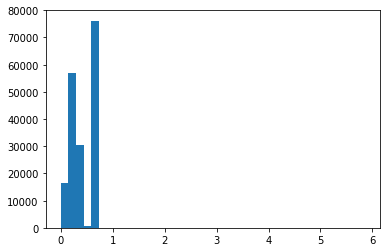

In [66]:
plt.hist(np.log1p(b),bins=40);
b.median()

In [103]:
a['ratio']=a[ 'totalassessedvalue' ]/a['totalmarketvalue']

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [104]:
b=(a[ 'totalassessedvalue' ]/a['totalmarketvalue']).dropna()
b=np.round(b,2)
b.shape, b.median()

((23295254,), 0.3499999940395355)

In [95]:
np.where(b==0)

(array([   73390,    87209,    91555,    92586,  2565352,  2593523,
         2608207,  2608226,  2608227,  2608229,  2608230,  2954835,
         2968654,  2973003,  2974034,  4997674,  4997675,  4997676,
         4997678,  4997679,  4997680,  4997683,  5396722,  5424893,
         5439579,  5439598,  5439599,  5439601,  5439602,  5786132,
         5799926,  5804273,  5805304,  8072764,  8079723,  8079724,
         8079725,  8079726,  8079727,  8079728,  8079729,  8079730,
         8079731,  8079732,  8079733,  8079775,  8079776,  8079777,
         8079778,  8079779,  8079780,  8079781,  8100936,  8115622,
         8115641,  8115642,  8115644,  8115645,  8423836,  8437598,
         8441936,  8442965,  9908663,  9908676, 10376616, 10418562,
        10418563, 10419740, 10419742, 10419743, 10419744, 10419749,
        10419750, 10419752, 10419765, 10419766, 10419827, 10419840,
        10419848, 10419849, 10419850, 10419851, 10419852, 10599395,
        10613152, 10617489, 10618517, 10621601, 

In [108]:
b.loc[b.index[10419850]]

0.0

In [105]:
taxdata.loc[b.index[10419850]]

assessmentyear                   2013
parcelid                    112056162
totalassessedvalue                410
taxamount                     5482.66
taxvaluedollarcnt               86220
landassessedvalue                 410
totalmarketvalue                86220
improvementassessedvalue          nan
state                              39
county                          39017
Name: 32536727, dtype: object

In [107]:
a.loc[b.index[10419848]]

assessmentyear                    2013
parcelid                     112056164
totalassessedvalue                 420
taxamount                      6060.54
taxvaluedollarcnt                87870
landassessedvalue                  420
totalmarketvalue                 87870
improvementassessedvalue           nan
state                               39
county                           39017
ratio                       0.00477979
Name: 32536725, dtype: object

In [53]:
a.shape

(25840247, 10)

In [98]:
salesdata[salesdata.parcelid==112056162].T

6467430
regionidcounty                                  904
transactionyear                                2016
recordingdate                   2016-12-27 00:00:00
parcelid                                  112056162
legalrecordingid                          561503630
createdate                      2017-01-27 00:00:00
documenttypeid                                  129
concurrentloanamount                         212000
concurrentloancount                               1
dataclasstypeid                                   5
deedsloanamount                              212000
loanamount                                   212000
loancount                                         1
saleprice                                    265000
partialinteresttransferpercent                  NaN
partialinteresttransfertypeid                   NaN
inclusionruleidzestimate                          0
derivedloanamount                               NaN
derivedloancount                                NaN
sellertype                                    55,55
numseller                                         2
buyertype                                     42,42
numbuyer                                          2
state                                            39
county                                        39017
tract                                   39017011118

In [99]:
a[a.parcelid==112056162].sort_values('assessmentyear')

assessmentyear   parcelid  totalassessedvalue    taxamount  \
80742806            2007  112056162             95771.0  4845.220215   
72948989            2008  112056162            111976.0  4792.759766   
65519080            2009  112056162            108703.0  4832.060059   
57638083            2010  112056162            108703.0    21.500000   
48933958            2011  112056162            105431.0    22.100000   
40462474            2012  112056162               410.0    22.100000   
32536727            2013  112056162               410.0  5482.660156   
25566151            2014  112056162               410.0  5482.660156   
16850618            2015  112056162               410.0  5310.660156   
7573652             2016  112056162               410.0  5283.879883   

          taxvaluedollarcnt  landassessedvalue  totalmarketvalue  \
80742806           273630.0            14431.0          273630.0   
72948989           319930.0            30177.0          319930.0   
65519080           310580.0            30177.0          310580.0   
57638083           310580.0            30177.0          310580.0   
48933958           301230.0            30177.0          301230.0   
40462474            86220.0              410.0           86220.0   
32536727            86220.0              410.0           86220.0   
25566151            60720.0              410.0           60720.0   
16850618            60720.0              410.0           60720.0   
7573652             60720.0              410.0           60720.0   

          improvementassessedvalue state county  
80742806                   81340.0    39  39017  
72948989                   81799.0    39  39017  
65519080                   78526.0    39  39017  
57638083                   78526.0    39  39017  
48933958                   75254.0    39  39017  
40462474                       NaN    39  39017  
32536727                       NaN    39  39017  
25566151                       NaN    39  39017  
16850618                       NaN    39  39017  
7573652                        NaN    39  39017

In [55]:
b[b<>1].shape,b.shape

((441041,), (17279498,))

In [56]:
len(set(a.loc[b[b<>1].index,'parcelid']).intersection(subsales['parcelid']))

68581

In [77]:
c=taxdata[taxdata.parcelid.isin(set(a.loc[b[b<>1].index,'parcelid']).intersection(subsales['parcelid']))]
c['ratio']=c['totalmarketvalue']/c['totalassessedvalue']
c=c.sort_values('ratio',ascending=False)

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [79]:
c.head()

assessmentyear   parcelid  totalassessedvalue   taxamount  \
59203693            2010  103124085                 1.0         NaN   
66678742            2009  103124085                 1.0         NaN   
32919588            2013  107639615                10.0         NaN   
40840291            2012  107639615                10.0         NaN   
1434797             2017  102693580               110.0  871.049988   

          taxvaluedollarcnt  landassessedvalue  totalmarketvalue  \
59203693           350000.0                1.0          350000.0   
66678742           350000.0                1.0          350000.0   
32919588            17020.0                NaN           17020.0   
40840291            17020.0                NaN           17020.0   
1434797            158980.0                NaN          158980.0   

          improvementassessedvalue state county          ratio  
59203693                       NaN    37  37031  350000.000000  
66678742                       NaN    37  37031  350000.000000  
32919588                       NaN    37  37147    1702.000000  
40840291                       NaN    37  37147    1702.000000  
1434797                      110.0    37  37019    1445.272705

In [57]:
list(set(a.loc[b[b<>1].index,'parcelid']).intersection(subsales['parcelid']))[:100]

[105644033,
 108309163,
 105119748,
 102629381,
 106823687,
 108309164,
 106823694,
 105644051,
 108309166,
 105644054,
 106858474,
 102498331,
 102629407,
 108789792,
 105644066,
 108789795,
 102629414,
 106212017,
 108352860,
 108352861,
 105250865,
 108309171,
 102629429,
 105250871,
 102629432,
 105250874,
 105644092,
 108789821,
 108789822,
 108789823,
 105250880,
 105119809,
 105119810,
 105250888,
 106823753,
 108789835,
 108789836,
 106823767,
 108789848,
 105644123,
 105603936,
 102629477,
 105644134,
 106227369,
 102629480,
 102629481,
 102629482,
 108789867,
 108789868,
 108789870,
 108789873,
 108789874,
 102629491,
 105644148,
 102629493,
 105644150,
 108309183,
 105382014,
 108308703,
 108805911,
 106212032,
 108789890,
 108261930,
 108789892,
 102629509,
 105250951,
 108789897,
 108265612,
 108309186,
 102629518,
 102629522,
 108789909,
 102629526,
 102629528,
 105119897,
 102629530,
 108789915,
 102629533,
 108789919,
 108352880,
 102629538,
 103153829,
 102629542,
 102

In [84]:
sale_tax=pd.merge(subsales,taxdata, left_on=['parcelid',u'transactionyear'], 
                  right_on=['parcelid',u'assessmentyear'],how='left')
sale_tax['ratio']=sale_tax['saleprice']/sale_tax[u'totalassessedvalue']
sale_tax=sale_tax.sort_values('ratio',ascending=False)
sale_tax=sale_tax[sale_tax['inclusionruleidzestimate']>0]

In [118]:
sale_tax[sale_tax.ratio<5].head()

regionidcounty  transactionyear recordingdate   parcelid  \
1518716             962             2008    2008-05-12  103361410   
1474159             999             2010    2010-06-24  103952886   
1730721             324             2015    2015-01-07   97638582   
1129989            1712             2014    2014-11-25  104153534   
537820             2640             2016    2016-04-11  102630929   

         legalrecordingid createdate  documenttypeid  concurrentloanamount  \
1518716         435094574 2016-01-29           138.0                   NaN   
1474159         435523305 2016-01-29           138.0              201158.0   
1730721         176122040 2016-01-29           138.0              515516.0   
1129989         436597514 2016-01-29           128.0              143398.0   
537820          544530552 2016-08-23           128.0                   NaN   

         concurrentloancount  dataclasstypeid    ...     assessmentyear  \
1518716                  NaN              2.0    ...             2008.0   
1474159                  1.0              5.0    ...             2010.0   
1730721                  1.0              5.0    ...             2015.0   
1129989                  1.0              5.0    ...             2014.0   
537820                   NaN              2.0    ...             2016.0   

         totalassessedvalue    taxamount  taxvaluedollarcnt  \
1518716             41020.0          NaN            41020.0   
1474159             41025.0   532.419983            41025.0   
1730721            129000.0  5563.620117           129000.0   
1129989             29325.0   368.239990            29325.0   
537820              21220.0  1110.849976           121060.0   

         landassessedvalue  totalmarketvalue  improvementassessedvalue  \
1518716             2600.0           41020.0                   38420.0   
1474159            41025.0               NaN                       NaN   
1730721           129000.0          129000.0                       NaN   
1129989            29325.0               NaN                       NaN   
537820             20000.0          121060.0                    1220.0   

         state_y  county_y     ratio  
1518716       37     37049  4.997562  
1474159       37     37063  4.996953  
1730721       37     37183  4.996124  
1129989       37     37067  4.995738  
537820        37     37019  4.995287  

[5 rows x 36 columns]

In [116]:
a=sale_tax[sale_tax.ratio>3]
a=a[a.ratio<10]
a.shape

(45663, 36)

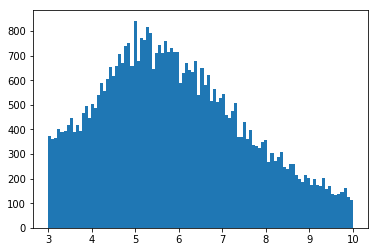

In [117]:
plt.hist( a.ratio,bins=100);

In [121]:
a.assessmentyear.value_counts()

2015.0    6185
2007.0    5638
2014.0    5528
2013.0    5196
2016.0    5125
2012.0    3826
2008.0    3601
2010.0    3282
2009.0    3165
2011.0    2919
2017.0    1198
Name: assessmentyear, dtype: int64

In [125]:
a[u'county_x'].value_counts()

37119    12502
37063     5081
37183     4535
37179     4329
37025     3420
37051     2725
37019     2302
37097     2042
37081     1562
37085     1261
37067      901
37021      634
37049      620
37071      472
37133      355
37001      320
37037      225
37089      183
37057      174
37157      172
37147      163
37151      155
37139      120
37129      119
37069       99
37141       99
37027       87
37077       81
37109       78
37135       62
         ...  
37059       12
37167       11
37015       11
37145       10
37191       10
37111        9
37169        8
37099        8
37039        7
37165        6
37113        6
37159        6
37103        5
37073        4
37123        4
37171        4
37009        4
37117        3
37115        3
37003        3
37181        3
37107        2
37185        2
37091        2
37005        2
37075        1
37043        1
37137        1
37029        1
37193        1
Name: county_x, Length: 79, dtype: int64